Q1) Dataset contains Monthly and Daily prices of Natural gas, starting from January 1997 to current year. Prices are in nominal dollars. The task is to predict the price of natural gas using RNN model
for the dataset
https://datahub.io/core/natural-gas#resource-daily 
https://www.kaggle.com/datasets/joebeachcapital/natural-gas-prices

Given the price of last ten 10 days, corresponds to sequence_length, the RNN model must predict
the price for the 11th day

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [6]:

# Replace with your actual file path
file_path = "/home/mustafa/dllab/w8prac/q1/daily_csv.csv"

# Load the dataset
df = pd.read_csv(file_path)

# Display the first few rows
print(df.head())

# Convert date column to datetime format
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Use only price column
prices = df["Price"].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)


         Date  Price
0  1997-01-07   3.82
1  1997-01-08   3.80
2  1997-01-09   3.61
3  1997-01-10   3.92
4  1997-01-13   4.00


In [8]:
class NaturalGasDataset(Dataset):
    def __init__(self, data, seq_length=10):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.seq_length]
        y = self.data[idx + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Split data into train (80%) and test (20%)
train_size = int(0.8 * len(prices_scaled))
train_data, test_data = prices_scaled[:train_size], prices_scaled[train_size:]

train_dataset = NaturalGasDataset(train_data)
test_dataset = NaturalGasDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [9]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        return self.fc(out[:, -1, :])

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNModel().to(device)


In [10]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch = X_batch.view(X_batch.shape[0], X_batch.shape[1], 1)  # Reshape for RNN

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.5f}")


/home/mustafa/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 0.01749
Epoch 2, Loss: 0.01730
Epoch 3, Loss: 0.01719
Epoch 4, Loss: 0.01724
Epoch 5, Loss: 0.01721
Epoch 6, Loss: 0.01719
Epoch 7, Loss: 0.01722
Epoch 8, Loss: 0.01712
Epoch 9, Loss: 0.01718
Epoch 10, Loss: 0.01715
Epoch 11, Loss: 0.01714
Epoch 12, Loss: 0.01711
Epoch 13, Loss: 0.01711
Epoch 14, Loss: 0.01714
Epoch 15, Loss: 0.01713
Epoch 16, Loss: 0.01713
Epoch 17, Loss: 0.01712
Epoch 18, Loss: 0.01710
Epoch 19, Loss: 0.01710
Epoch 20, Loss: 0.01713
Epoch 21, Loss: 0.01714
Epoch 22, Loss: 0.01711
Epoch 23, Loss: 0.01710
Epoch 24, Loss: 0.01715
Epoch 25, Loss: 0.01709
Epoch 26, Loss: 0.01707
Epoch 27, Loss: 0.01709
Epoch 28, Loss: 0.01705
Epoch 29, Loss: 0.01711
Epoch 30, Loss: 0.01708
Epoch 31, Loss: 0.01712
Epoch 32, Loss: 0.01715
Epoch 33, Loss: 0.01713
Epoch 34, Loss: 0.01711
Epoch 35, Loss: 0.01711
Epoch 36, Loss: 0.01710
Epoch 37, Loss: 0.01709
Epoch 38, Loss: 0.01708
Epoch 39, Loss: 0.01710
Epoch 40, Loss: 0.01708
Epoch 41, Loss: 0.01711
Epoch 42, Loss: 0.01708
E

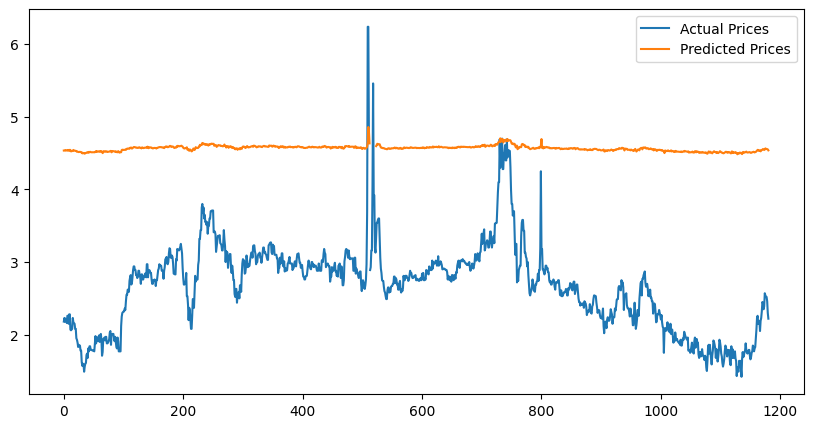

In [11]:
model.eval()
predictions, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device).view(1, -1, 1)
        y_batch = y_batch.item()

        pred = model(X_batch).item()

        predictions.append(pred)
        actuals.append(y_batch)

# Convert predictions back to original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

plt.figure(figsize=(10, 5))
plt.plot(actuals, label="Actual Prices")
plt.plot(predictions, label="Predicted Prices")
plt.legend()
plt.show()


In [12]:
import torch
import numpy as np

# Select last 10 days from the dataset
last_10_days = prices_scaled[-10:].reshape(1, 10, 1)  # Reshape to (batch_size, seq_length, input_size)
last_10_days_tensor = torch.tensor(last_10_days, dtype=torch.float32).to(device)
model.eval()

# Predict the 11th day's price
with torch.no_grad():
    predicted_scaled = model(last_10_days_tensor).cpu().numpy()

# Convert back to original price scale
predicted_price = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))

print(f"Predicted 11th Day Price: ${predicted_price[0][0]:.2f}")


Predicted 11th Day Price: $4.54


Q2) The data provided at the link https://download.pytorch.org/tutorial/data.zip consists of
names stored in the format {language: [names ...]} i.e. each language contains a list of
names. Train a RNN on a few thousand surnames from 18 languages of origin, and
predict which language a name is from based on the spelling.

In [13]:
import glob
import os
import unicodedata
import string

# Characters allowed (A-Z + lowercase + punctuation)
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

# Function to read names from files
def read_names(filename):
    with open(filename, encoding='utf-8') as f:
        return [line.strip() for line in f.readlines()]

# Load names for each language
language_names = {}
for filepath in glob.glob("data/names/*.txt"):
    language = os.path.splitext(os.path.basename(filepath))[0]
    language_names[language] = read_names(filepath)

# List of all languages
languages = list(language_names.keys())
N_LANGUAGES = len(languages)

print(f"Loaded {len(languages)} languages and {sum(len(v) for v in language_names.values())} names.")


Loaded 18 languages and 20074 names.


In [14]:
import torch

# Convert a character to a tensor representation
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Convert a name to a tensor (sequence of one-hot encoded letters)
def name_to_tensor(name):
    tensor = torch.zeros(len(name), 1, N_LETTERS)
    for i, letter in enumerate(name):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor


In [15]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden):
        combined = torch.cat((input_tensor, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return self.softmax(output), hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)


In [16]:
import random

# Convert a language to a one-hot encoded tensor
def language_to_tensor(language):
    tensor = torch.zeros(1, N_LANGUAGES)
    tensor[0][languages.index(language)] = 1
    return tensor

# Get a random training example
def random_training_example():
    language = random.choice(languages)
    name = random.choice(language_names[language])
    name_tensor = name_to_tensor(name)
    language_tensor = torch.tensor([languages.index(language)], dtype=torch.long)
    return name, language, name_tensor, language_tensor

print(random_training_example())


('Paterson', 'Scottish', tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      

In [17]:
import torch.optim as optim

HIDDEN_SIZE = 128
model = RNN(N_LETTERS, HIDDEN_SIZE, N_LANGUAGES)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

def train(name_tensor, language_tensor):
    hidden = model.init_hidden()
    model.zero_grad()

    for i in range(name_tensor.size()[0]):
        output, hidden = model(name_tensor[i], hidden)

    loss = criterion(output, language_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()

# Train for 100,000 iterations
for iter in range(100000):
    name, language, name_tensor, language_tensor = random_training_example()
    output, loss = train(name_tensor, language_tensor)

    if iter % 5000 == 0:
        print(f"Iteration {iter} | Loss: {loss:.4f}")


Iteration 0 | Loss: 2.7845
Iteration 5000 | Loss: 2.6390
Iteration 10000 | Loss: 1.9523
Iteration 15000 | Loss: 2.7177
Iteration 20000 | Loss: 1.4110
Iteration 25000 | Loss: 2.0555
Iteration 30000 | Loss: 0.3315
Iteration 35000 | Loss: 3.2625
Iteration 40000 | Loss: 0.5763
Iteration 45000 | Loss: 1.4183
Iteration 50000 | Loss: 1.1195
Iteration 55000 | Loss: 0.9053
Iteration 60000 | Loss: 2.1858
Iteration 65000 | Loss: 1.0731
Iteration 70000 | Loss: 2.8974
Iteration 75000 | Loss: 0.7620
Iteration 80000 | Loss: 1.7426
Iteration 85000 | Loss: 2.0665
Iteration 90000 | Loss: 1.2791
Iteration 95000 | Loss: 2.9343


In [18]:
def predict(name):
    model.eval()
    hidden = model.init_hidden()
    name_tensor = name_to_tensor(name)

    for i in range(name_tensor.size()[0]):
        output, hidden = model(name_tensor[i], hidden)

    _, predicted_index = output.topk(1)
    predicted_language = languages[predicted_index[0].item()]
    return predicted_language

# Example Predictions
print(predict("Schmidt"))   # German
print(predict("Yamamoto"))  # Japanese
print(predict("Kumar"))     # Indian
print(predict("Garcia"))    # Spanish


French
Japanese
German
Arabic


3. Implement a next character predictor using RNN Model

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

# Sample text dataset
text = "hello world"

# Unique characters and their indices
chars = list(set(text))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for ch, i in char_to_idx.items()}

# Convert text to indices
text_indices = [char_to_idx[ch] for ch in text]

# Hyperparameters
sequence_length = 3  # Use last 3 characters to predict the next one
hidden_size = 128
num_epochs = 500
lr = 0.01

# Prepare Training Data
X_train = []
Y_train = []

for i in range(len(text_indices) - sequence_length):
    X_train.append(text_indices[i:i+sequence_length])
    Y_train.append(text_indices[i+sequence_length])

X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)

# Define the RNN Model
class CharRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embed(x.long())
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])  # Predict next character
        return out, hidden

# Train the Model
model = CharRNN(len(chars), hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    hidden = torch.zeros(1, X_train.shape[0], hidden_size)
    outputs, _ = model(X_train, hidden)
    
    loss = criterion(outputs, Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Function to Predict Next Character
def predict_next(model, input_text):
    model.eval()
    input_indices = [char_to_idx[ch] for ch in input_text]
    input_tensor = torch.tensor([input_indices], dtype=torch.float32)
    hidden = torch.zeros(1, 1, hidden_size)

    with torch.no_grad():
        output, _ = model(input_tensor, hidden)
        predicted_idx = torch.argmax(output, dim=1).item()
    
    return idx_to_char[predicted_idx]

# Test Prediction
input_text = "wor"
predicted_char = predict_next(model, input_text)
print(f'Next character after "{input_text}": {predicted_char}')


Epoch [50/500], Loss: 0.0001
Epoch [100/500], Loss: 0.0001
Epoch [150/500], Loss: 0.0000
Epoch [200/500], Loss: 0.0000
Epoch [250/500], Loss: 0.0000
Epoch [300/500], Loss: 0.0000
Epoch [350/500], Loss: 0.0000
Epoch [400/500], Loss: 0.0000
Epoch [450/500], Loss: 0.0000
Epoch [500/500], Loss: 0.0000
Next character after "wor": l
